# Importing
Making sure that cuda is properly installed and is available as the training device

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
print("Backend:", keras.backend.backend())

2025-10-18 23:46:41.684691: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 23:46:41.717927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-18 23:46:42.855419: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Backend: tensorflow


# Data
The data is from https://www.kaggle.com/datasets/stealthtechnologies/rock-classification. 
They are imported using the keras image dataset from directory method, reduced to (360, 360), normalised and prefetched. This loads the next batch of images into RAM while the previous batch is training on the GPU, which speeds up the overall processing.

The dataset is already pre-processed and augmented with the following steps being taken, as discussed in the dataset description in the link above:

    Auto-orientation of pixel data (with EXIF-orientation stripping)
    Resize to 640x640 (Stretch)

The following augmentation was applied to create 3 versions of each source image:

    50% probability of horizontal flip
    Randomly crop between 0 and 20 percent of the image
    Random shear of between -10° to +10° horizontally and -10° to +10° vertically
    Random brigthness adjustment of between -15 and +15 percent
    Random exposure adjustment of between -10 and +10 percent
    Salt and pepper noise was applied to 0.1 percent of pixels


In [2]:
train_dir = r'Rock Data/train'
test_dir = r'Rock Data/test'
valid_dir = r'Rock Data/valid'

# Image parameters
img_size = (360,360) # OG is 640,640
batch_size = 16 # Had to reduce batch size from 32 because I was hitting into max GPU memory

# Load training dataset
train_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Load validation dataset
valid_dataset = keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Load validation dataset
test_dataset = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

print("Class names:", train_dataset.class_names)
num_classes = len(train_dataset.class_names)

# prefetch for performance
train_dataset = train_dataset.prefetch(buffer_size=32)
valid_dataset = valid_dataset.prefetch(buffer_size=32)
test_dataset = test_dataset.prefetch(buffer_size=32)

# Normalise images
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
valid_dataset = valid_dataset.map(lambda x, y: (x / 255.0, y))
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))

Found 3687 files belonging to 9 classes.
Found 351 files belonging to 9 classes.
Found 174 files belonging to 9 classes.
Class names: ['Basalt', 'Clay', 'Conglomerate', 'Diatomite', 'Shale-(Mudstone)', 'Siliceous-sinter', 'chert', 'gypsum', 'olivine-basalt']


I0000 00:00:1760824006.382340    3936 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6166 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


# Model choice

I used a coditional GAN in Keras. Keras does not have a fitting code for GANs like it does for something like CNN, so I had to custom make one using tf.GradientTape. This was then optimised using Adam, with different rates for the generator and discriminator (2e-4 vs 1e-4) to keep training balanced. Due to GPU memory limits I had to use batch_size=16 and 360×360 images, which increases variance and training time. The balance of the training was also an issue, which was helped by reducing the training rate for the discriminator, and adding dropout to it. The target was for both the generator loss and discriminator loss to be around the same for each iteration, so that one does not dominate as can be seen from the below before the changes:

    Epoch 57: D_loss=0.088, G_loss=11.494
    Epoch 58: D_loss=0.023, G_loss=5.449
    Epoch 59: D_loss=0.028, G_loss=5.938
    Epoch 60: D_loss=0.193, G_loss=5.176

In [3]:
import tensorflow as tf
from keras import layers

# Generator
def build_generator():
    
    # z is the input for the random noise that will become the image, y is the input for the label
    z_in = layers.Input(shape=(128,), name="z")
    y_in = layers.Input(shape=(), dtype="int32", name="label")

    # Generating an embedding, for each label embedding
    y = layers.Embedding(num_classes, 128)(y_in)        # shape (None, latent_dim)
    
    # Fuse with the random noise, so that the result is the random noise and the embedded label
    zy = layers.Concatenate()([z_in, y])                       # shape (None, 2*latent_dim)

    # Start of the generating
    start = img_size[0] // 8  # starting from 8x lower than the image size
    x = layers.Dense(start * start * 256, use_bias=False)(zy)
    x = layers.Reshape((start, start, 256))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Upsampling 3 times until we get to the desired size
    for filters in [128, 64, 32]:
        x = layers.Conv2DTranspose(filters, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    # Create the final RGB image for the output
    img_out = layers.Conv2D(3, kernel_size=3, padding="same", activation="sigmoid")(x)
    return keras.Model([z_in, y_in], img_out, name="generator")

# Discriminator
def build_discriminator():
    # This is just a pretty standard CNN, with an extra label channel
    x_in = layers.Input(shape=(img_size[0],img_size[1], 3), name="image")
    y_in = layers.Input(shape=(), dtype="int32", name="label")

    # Use embedding again for the classes, and join it with the input image
    y = layers.Embedding(num_classes, img_size[0] **2 )(y_in)
    y = layers.Reshape((img_size[0],img_size[1], 1))(y)
    xy = layers.Concatenate(axis=-1)([x_in, y])
    
    # Layers, leaky relu to avoid neuron death, and dropout so that the discriminator doesn't get too good too quick when compared to the generator
    x = layers.Conv2D(64, 4, strides=2, padding="same")(xy)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, 4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(256, 4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(512, 4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Flatten()(x)
    output = layers.Dense(1)(x) # 0 for fake images and 1 for real images.
    return keras.Model([x_in, y_in], output, name="discriminator")

generator = build_generator()
discriminator = build_discriminator()

# Defining optimisers and the loss function
latent_dim = 128
g_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True) # We have to use this because we didn't put a activation function on the output

@tf.function
def train_step(real_images, labels):
    # To make one step of training
    batch_size = tf.shape(real_images)[0]
    random_latent = tf.random.normal((batch_size, latent_dim)) # The random noise vectors to be given to the generator

    # Train Discriminator
    with tf.GradientTape() as tape: # The tape records the computations done within it, so that we can then get the gradient and backpropagate
        fake_images = generator([random_latent, labels], training=True)
        real_logits = discriminator([real_images, labels], training=True)
        fake_logits = discriminator([fake_images, labels], training=True)
        d_loss = (loss_fn(tf.ones_like(real_logits), real_logits) + # Rewarding values close to 1 for real
                  loss_fn(tf.zeros_like(fake_logits), fake_logits)) # and close to 0 for fake
    grads = tape.gradient(d_loss, discriminator.trainable_weights) # Computing the gradients
    d_opt.apply_gradients(zip(grads, discriminator.trainable_weights)) # Giving them to the optimiser

    # Train Generator
    random_latent = tf.random.normal((batch_size, latent_dim)) # random images
    with tf.GradientTape() as tape:
        fake_images = generator([random_latent, labels], training=True)
        fake_logits = discriminator([fake_images, labels], training=True) # More simple for the generator, just whether or not it can trick the discriminator 
        g_loss = loss_fn(tf.ones_like(fake_logits), fake_logits)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_opt.apply_gradients(zip(grads, generator.trainable_weights))

    return d_loss, g_loss # Returning the losses so I can then print them


# Training loop
epochs = 150
for epoch in range(epochs):
    for real_images, labels in train_dataset: 
        d_loss, g_loss = train_step(real_images, labels)
    print(f"Epoch {epoch+1}: D_loss={d_loss:.3f}, G_loss={g_loss:.3f}")
    
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")

E0000 00:00:1760824023.466069    3936 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-10-18 23:47:04.247369: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
E0000 00:00:1760824145.640670    3936 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-10-18 23:49:10.140628: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1: D_loss=4.277, G_loss=0.419


2025-10-18 23:51:00.132109: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2: D_loss=3.181, G_loss=0.081
Epoch 3: D_loss=3.320, G_loss=0.678


2025-10-18 23:54:41.301022: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4: D_loss=3.725, G_loss=0.050
Epoch 5: D_loss=3.967, G_loss=0.234
Epoch 6: D_loss=3.235, G_loss=0.267
Epoch 7: D_loss=3.992, G_loss=1.048


2025-10-19 00:02:05.788280: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8: D_loss=4.037, G_loss=0.060
Epoch 9: D_loss=4.501, G_loss=1.199
Epoch 10: D_loss=4.538, G_loss=0.203
Epoch 11: D_loss=2.038, G_loss=0.114
Epoch 12: D_loss=2.181, G_loss=1.270
Epoch 13: D_loss=1.996, G_loss=0.411
Epoch 14: D_loss=1.298, G_loss=0.736
Epoch 15: D_loss=1.650, G_loss=1.250


2025-10-19 00:16:46.395484: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16: D_loss=1.794, G_loss=0.787
Epoch 17: D_loss=2.035, G_loss=0.391
Epoch 18: D_loss=1.026, G_loss=1.455
Epoch 19: D_loss=2.831, G_loss=0.424
Epoch 20: D_loss=0.722, G_loss=1.849
Epoch 21: D_loss=4.740, G_loss=0.661
Epoch 22: D_loss=0.643, G_loss=3.367
Epoch 23: D_loss=0.288, G_loss=2.319
Epoch 24: D_loss=1.305, G_loss=1.503
Epoch 25: D_loss=1.311, G_loss=1.494
Epoch 26: D_loss=3.181, G_loss=0.404
Epoch 27: D_loss=0.800, G_loss=1.294
Epoch 28: D_loss=1.407, G_loss=3.527
Epoch 29: D_loss=1.632, G_loss=0.604
Epoch 30: D_loss=1.193, G_loss=1.835
Epoch 31: D_loss=1.653, G_loss=0.130


2025-10-19 00:46:13.850327: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32: D_loss=0.782, G_loss=1.939
Epoch 33: D_loss=0.928, G_loss=3.474
Epoch 34: D_loss=3.830, G_loss=0.593
Epoch 35: D_loss=0.862, G_loss=1.455
Epoch 36: D_loss=0.991, G_loss=3.151
Epoch 37: D_loss=1.176, G_loss=2.759
Epoch 38: D_loss=2.039, G_loss=3.155
Epoch 39: D_loss=1.100, G_loss=2.090
Epoch 40: D_loss=2.398, G_loss=3.904
Epoch 41: D_loss=1.173, G_loss=3.294
Epoch 42: D_loss=0.319, G_loss=1.959
Epoch 43: D_loss=0.407, G_loss=2.479
Epoch 44: D_loss=0.377, G_loss=2.091
Epoch 45: D_loss=1.245, G_loss=0.532
Epoch 46: D_loss=1.045, G_loss=0.562
Epoch 47: D_loss=1.426, G_loss=1.535
Epoch 48: D_loss=0.639, G_loss=4.349
Epoch 49: D_loss=0.411, G_loss=4.337
Epoch 50: D_loss=3.792, G_loss=2.356
Epoch 51: D_loss=0.287, G_loss=3.632
Epoch 52: D_loss=0.818, G_loss=4.208
Epoch 53: D_loss=1.963, G_loss=2.506
Epoch 54: D_loss=0.478, G_loss=3.759
Epoch 55: D_loss=2.149, G_loss=0.371
Epoch 56: D_loss=0.334, G_loss=2.282
Epoch 57: D_loss=0.488, G_loss=2.503
Epoch 58: D_loss=1.468, G_loss=4.542
E

2025-10-19 01:44:27.494712: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64: D_loss=0.077, G_loss=5.360
Epoch 65: D_loss=0.879, G_loss=3.333
Epoch 66: D_loss=0.381, G_loss=3.558
Epoch 67: D_loss=0.361, G_loss=2.660
Epoch 68: D_loss=1.959, G_loss=1.891
Epoch 69: D_loss=0.652, G_loss=4.174
Epoch 70: D_loss=1.330, G_loss=1.080
Epoch 71: D_loss=1.301, G_loss=1.358
Epoch 72: D_loss=0.331, G_loss=4.050
Epoch 73: D_loss=0.237, G_loss=3.792
Epoch 74: D_loss=0.852, G_loss=3.565
Epoch 75: D_loss=0.884, G_loss=3.705
Epoch 76: D_loss=1.159, G_loss=3.264
Epoch 77: D_loss=0.356, G_loss=3.574
Epoch 78: D_loss=1.095, G_loss=0.662
Epoch 79: D_loss=0.568, G_loss=0.559
Epoch 80: D_loss=1.122, G_loss=3.244
Epoch 81: D_loss=0.120, G_loss=3.564
Epoch 82: D_loss=0.381, G_loss=1.801
Epoch 83: D_loss=0.261, G_loss=2.522
Epoch 84: D_loss=0.456, G_loss=3.775
Epoch 85: D_loss=0.707, G_loss=4.074
Epoch 86: D_loss=1.384, G_loss=3.832
Epoch 87: D_loss=0.626, G_loss=0.499
Epoch 88: D_loss=0.608, G_loss=2.482
Epoch 89: D_loss=0.454, G_loss=2.327
Epoch 90: D_loss=0.330, G_loss=0.909
E

2025-10-19 03:40:48.784463: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 128: D_loss=0.239, G_loss=6.240
Epoch 129: D_loss=1.575, G_loss=5.783
Epoch 130: D_loss=1.422, G_loss=4.531
Epoch 131: D_loss=2.109, G_loss=2.062
Epoch 132: D_loss=0.963, G_loss=1.287
Epoch 133: D_loss=0.801, G_loss=4.176
Epoch 134: D_loss=0.503, G_loss=2.408
Epoch 135: D_loss=0.752, G_loss=3.152
Epoch 136: D_loss=0.426, G_loss=3.377
Epoch 137: D_loss=0.588, G_loss=4.988
Epoch 138: D_loss=0.295, G_loss=2.521
Epoch 139: D_loss=0.839, G_loss=1.471
Epoch 140: D_loss=0.250, G_loss=9.205
Epoch 141: D_loss=0.250, G_loss=1.362
Epoch 142: D_loss=0.195, G_loss=3.579
Epoch 143: D_loss=0.202, G_loss=4.309
Epoch 144: D_loss=0.323, G_loss=4.274
Epoch 145: D_loss=0.828, G_loss=3.551
Epoch 146: D_loss=0.280, G_loss=3.113
Epoch 147: D_loss=1.177, G_loss=1.910
Epoch 148: D_loss=1.226, G_loss=3.537
Epoch 149: D_loss=0.729, G_loss=2.322


Epoch 150: D_loss=1.102, G_loss=4.272


# Visualisation
It's difficult to visualise the performance of GANs because the main metrics I'm exporting above, generator loss and discriminator loss are relative, so I decided on showing examples of the images generated after training by the generator, which can be seen below.

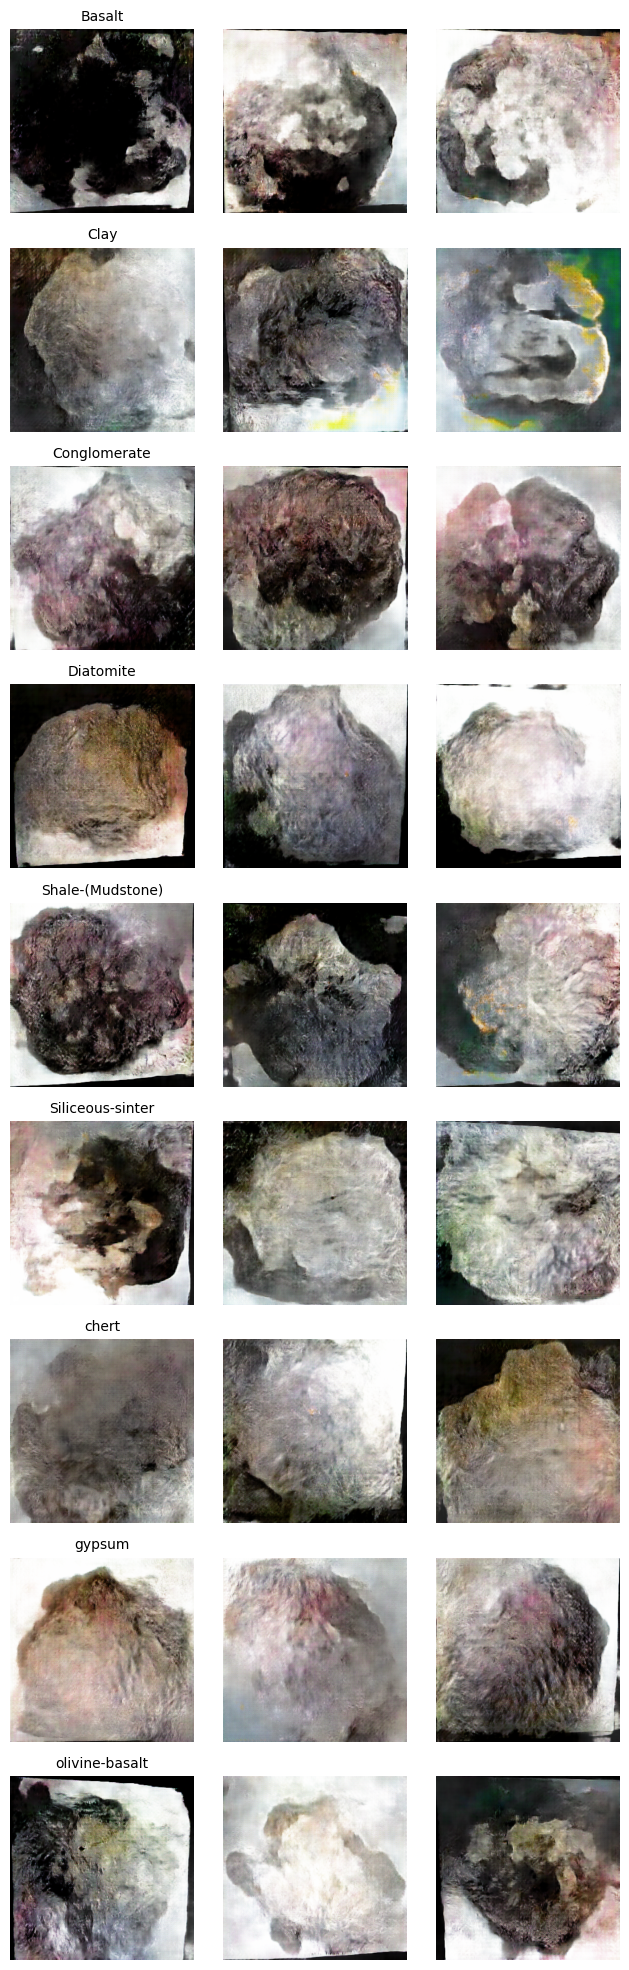

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Exporting 3 images for each sample
def show_class_samples(G, n_per_class=3):
    class_names = ['Basalt', 'Clay', 'Conglomerate', 'Diatomite', 'Shale-(Mudstone)', 'Siliceous-sinter', 'chert', 'gypsum', 'olivine-basalt']

    fig, axes = plt.subplots(num_classes, n_per_class, figsize=(n_per_class*2.2, num_classes*2.2))
    for i, cname in enumerate(class_names):
        z = tf.random.normal((n_per_class, latent_dim))
        y = tf.fill((n_per_class,), tf.cast(i, tf.int32))
        imgs = G([z, y], training=False).numpy()
        for j in range(n_per_class):
            ax = axes[i, j] if num_classes > 1 else axes[j]
            ax.imshow(np.clip(imgs[j], 0, 1))
            ax.axis("off")
            if j == 0:
                ax.set_title(cname, fontsize=10)
    plt.tight_layout()
    plt.show()

show_class_samples(generator)

# Relation to FAIR principles
Findable: the source dataset is referenced to Kaggle with consistent class folder names, which supports clear discovery. If possible the ipynb file will be uploaded in the code section to the dataset after the assignment to add to the findable nature.
Accessible: Open formats are used and the trained models are saved as .h5, so outputs can be loaded without custom code. 
Interoperable: inputs are common image formats and the workflow uses widely adopted libraries (TensorFlow/Keras). The code is written in python, and broken up into cells and functions.
Reusable: the notebook records key hyperparameters and architecture, with explanations of the steps taken included, additionally a requirements.txt would be included with the notebook.